# Previsão de Votação de Deputados

Modelos preditivos de regressão utilizando a biblioteca [scikit learn](http://scikit-learn.org/stable/index.html) para a predição dos votos de deputados federais considerando dados das últimas eleições.

Tutorial utilizado como base [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models)


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

C:\Users\rayan\AppData\Local\Temp\ipykernel_21376\2916246244.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [93]:
df_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#sample = pd.read_csv('sample_submission.csv')


In [ ]:
df_train.head(5)

In [ ]:
test.head(3)

### 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (10 pt.) 

Há desbalanceamento das classes. Exixtem muito mais candidatos não eleitos do que eleitos

In [95]:
df_train['situacao'].value_counts()

nao_eleito    6596
eleito        1026
Name: situacao, dtype: int64

# Porcentagem de candidatos não eleitos

In [98]:
nao_eleito = 6596/len(df_train) * 100
print(nao_eleito)

86.53896615061663


# Porcentagem de candidatos eleitos

In [99]:
eleitos = 100 - nao_eleito
print(eleitos)

13.46103384938337


## Observando os dados

In [58]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ano,7622.0,2.008121e+03,1.996485e+00,2006.0,2006.0000,2.010000e+03,2.010000e+03,2.010000e+03
sequencial_candidato,7622.0,9.039623e+10,9.893847e+10,10001.0,10555.0000,5.000000e+10,1.900000e+11,2.700000e+11
quantidade_doacoes,7622.0,2.767384e+01,1.165119e+02,1.0,4.0000,9.000000e+00,2.300000e+01,6.997000e+03
quantidade_doadores,7622.0,2.523996e+01,1.018049e+02,1.0,3.0000,8.000000e+00,2.100000e+01,5.800000e+03
total_receita,7622.0,1.732199e+05,4.444187e+05,0.0,2829.2075,1.334511e+04,1.046682e+05,5.690642e+06
media_receita,7622.0,5.456131e+03,1.400331e+04,0.0,625.0000,1.537775e+03,4.666247e+03,5.001800e+05
recursos_de_outros_candidatos.comites,7622.0,1.965750e+04,1.041636e+05,0.0,0.0000,1.125000e+03,6.196375e+03,3.664205e+06
recursos_de_pessoas_fisicas,7622.0,2.315820e+04,6.689215e+04,0.0,0.0000,1.350000e+03,1.574625e+04,1.403049e+06
recursos_de_pessoas_juridicas,7622.0,7.921689e+04,2.514138e+05,0.0,0.0000,0.000000e+00,1.725875e+04,3.178226e+06
recursos_proprios,7622.0,2.577600e+04,1.495312e+05,0.0,0.0000,1.121600e+03,9.600000e+03,5.525600e+06


## Distribuição das variáveis 

### Ao observar a sitruibuição do atributo total_receita podemos obeservar que ele está enviesado para a direta. Para resolver, utilizamos a transformação logarítmica.

array([[<AxesSubplot: title={'center': 'Total de Receita'}>]],
      dtype=object)

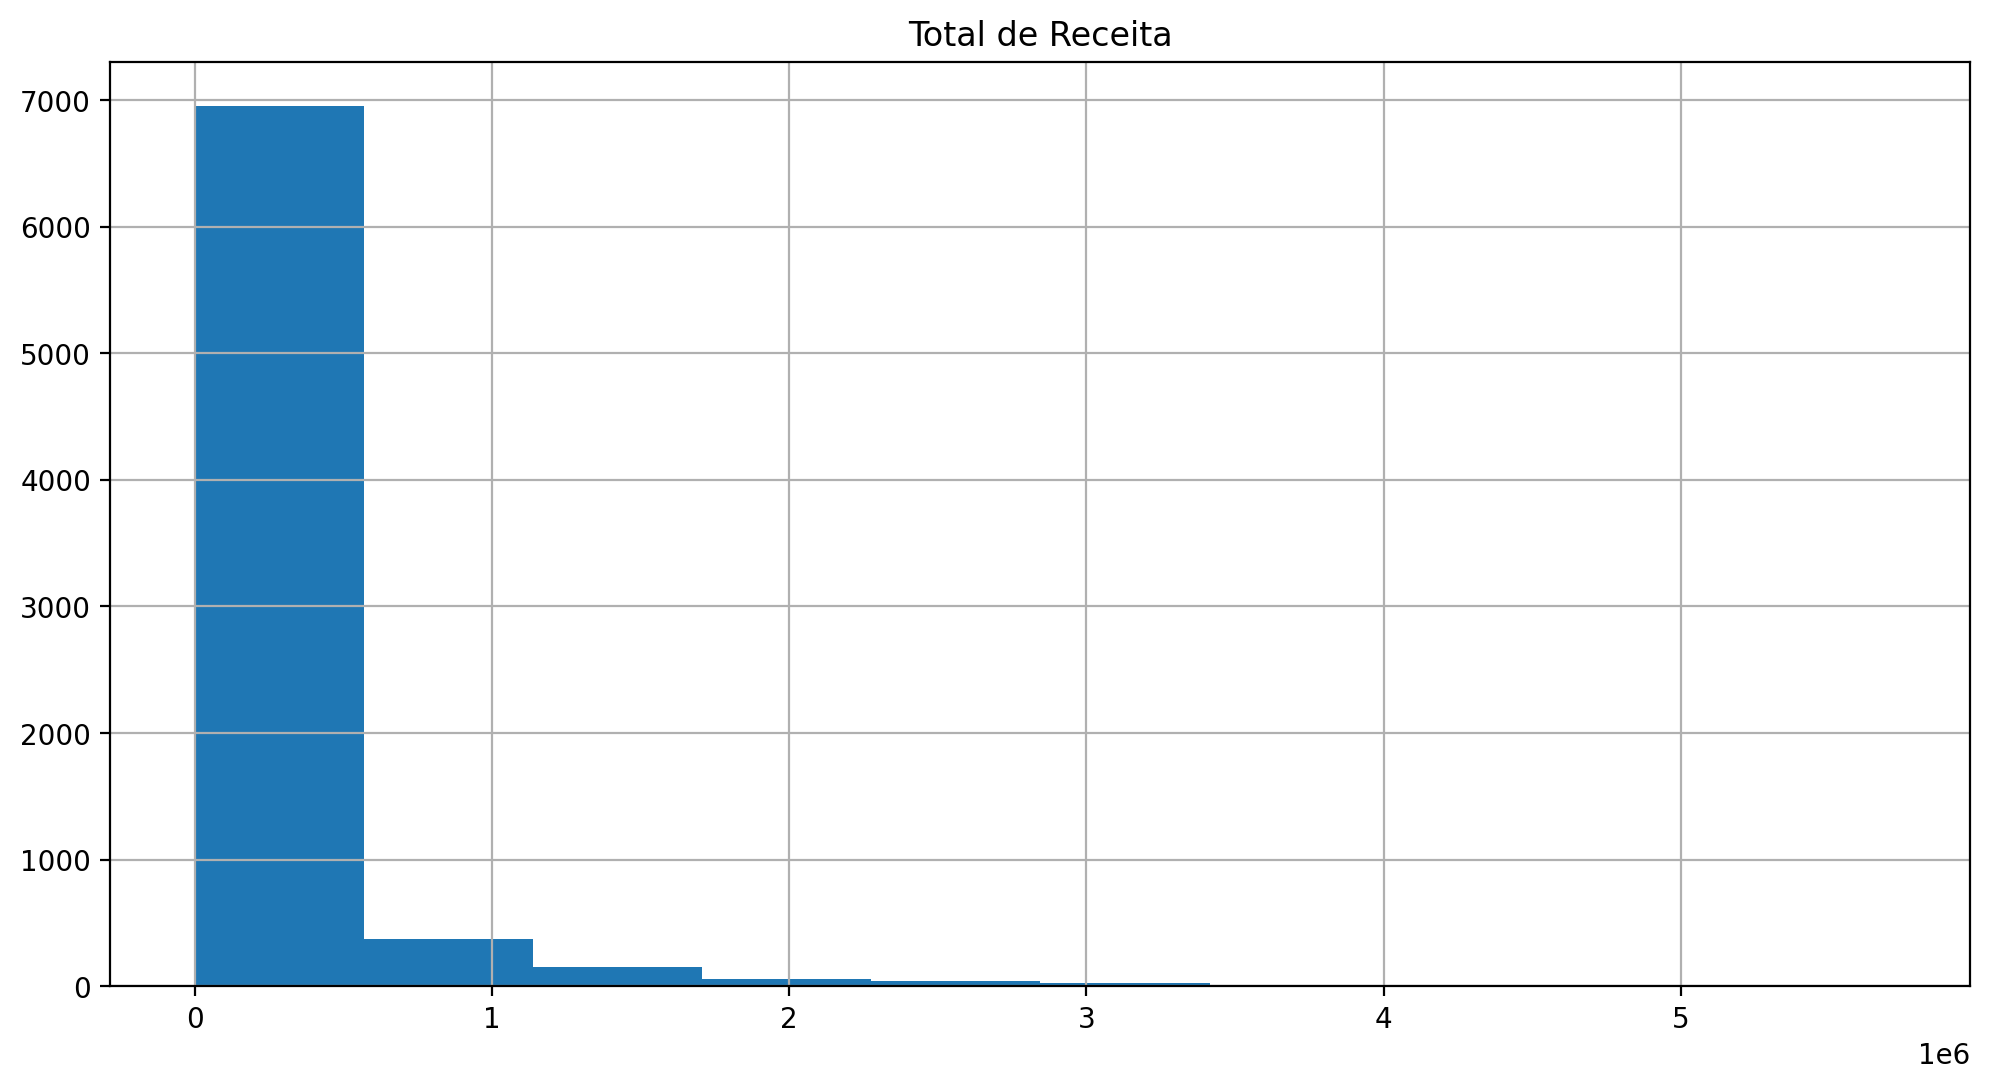

In [59]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
var = pd.DataFrame({"Total de Receita":df_train['total_receita']})

var.hist()

array([[<AxesSubplot: title={'center': 'log(total_receita + 1)'}>]],
      dtype=object)

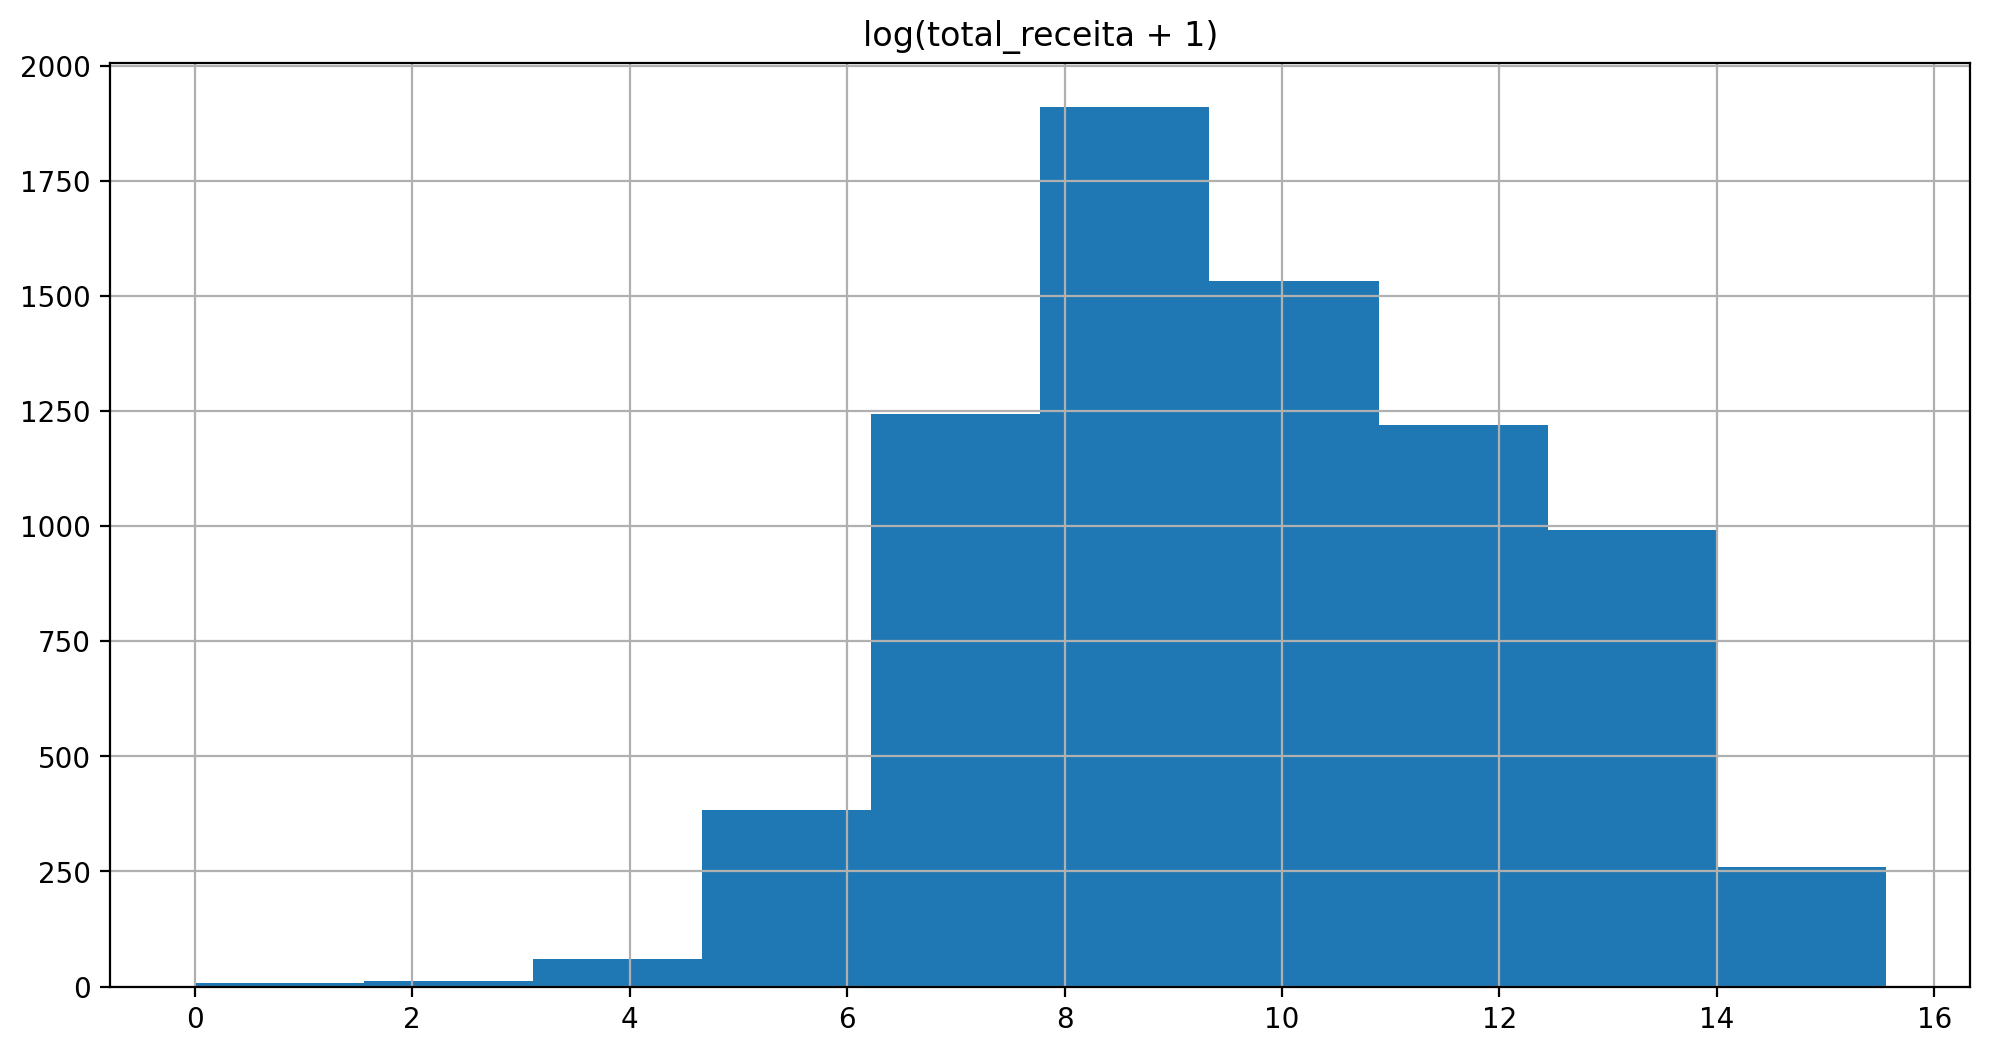

In [62]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
var = pd.DataFrame({"log(total_receita + 1)":np.log1p(df_train['total_receita'])})

var.hist()

### E para lidar com isso vamos fazer a mesma transformação anterior. Vamos replicar essa transformação para outras variáveis numéricas do conjunto de dados.

## Transformando variáveis numéricas

Selecionando as variáveis numéricas

In [63]:
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index
df_train[numeric_features][:5]

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa
0,2006,10001,6,6,16600.00,2766.67,0.0,9000.0,6300.00,1300.0,0.0,14,14,16583.60,1184.54
1,2006,10002,13,13,22826.00,1755.85,6625.0,15000.0,1000.00,201.0,0.0,24,23,20325.99,846.92
2,2006,10002,17,16,158120.80,9301.22,2250.0,34150.0,62220.80,59500.0,0.0,123,108,146011.70,1187.09
3,2006,10002,6,6,3001.12,500.19,0.0,1150.0,1101.12,750.0,0.0,8,8,3001.12,375.14
4,2006,10003,48,48,119820.00,2496.25,0.0,50878.0,0.00,68942.0,0.0,133,120,116416.64,875.31


Verificando o viés das variáveis numéricas

In [64]:
skewed_features = df_train[numeric_features].apply(lambda x: x.dropna().skew())
skewed_features

ano                                      -0.120947
sequencial_candidato                      0.468817
quantidade_doacoes                       40.628414
quantidade_doadores                      38.130533
total_receita                             4.734577
media_receita                            11.944468
recursos_de_outros_candidatos.comites    17.033492
recursos_de_pessoas_fisicas               8.269752
recursos_de_pessoas_juridicas             5.220351
recursos_proprios                        19.330136
recursos_de_partido_politico             10.250714
quantidade_despesas                       8.620600
quantidade_fornecedores                   8.493876
total_despesa                             4.584439
media_despesa                            70.104685
dtype: float64

Selecionando os atributos com viés acima de 0.75

In [65]:
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features

quantidade_doacoes                       40.628414
quantidade_doadores                      38.130533
total_receita                             4.734577
media_receita                            11.944468
recursos_de_outros_candidatos.comites    17.033492
recursos_de_pessoas_fisicas               8.269752
recursos_de_pessoas_juridicas             5.220351
recursos_proprios                        19.330136
recursos_de_partido_politico             10.250714
quantidade_despesas                       8.620600
quantidade_fornecedores                   8.493876
total_despesa                             4.584439
media_despesa                            70.104685
dtype: float64

Aplicando transformação logarítmica em todos os dados selecionados em skewed_features

In [66]:
skewed_features = skewed_features.index

df_train[skewed_features] = np.log1p(df_train[skewed_features])
df_train[numeric_features][:5]

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa
0,2006,10001,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,0.0,2.708050,2.708050,9.716230,7.077954
1,2006,10002,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,0.0,3.218876,3.178054,9.919705,6.742786
2,2006,10002,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,0.0,4.820282,4.691348,11.891449,7.080102
3,2006,10002,1.945910,1.945910,8.007074,6.216985,0.000000,7.048386,7.004991,6.621406,0.0,2.197225,2.197225,8.007074,5.929961
4,2006,10003,3.891820,3.891820,11.693754,7.822945,0.000000,10.837206,0.000000,11.141035,0.0,4.897840,4.795791,11.664939,6.775720


## Transformando variáveis categóricas

Verificando a quantidade de linhas e colunas do DataFrame antes da tranformação das variáveis categóricas

Convertendo atributos categóricos em valores modelo

In [67]:
df_train = pd.get_dummies(df_train)
df_train.shape

(7622, 7301)

Eleito = 1
Não eleito = 0

In [68]:
sample[:3]

,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,eleito
2,10000000158,nao_eleito


## Transformando atributos com valores NaN: 
Opção 1 - Preencher os valores NA's com a média de valores de cada coluna

In [69]:
train_mean = df_train.fillna(df_train.mean())

In [76]:
train_mean.head(3)

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,...,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA,situacao_eleito,situacao_nao_eleito
0,2006,10001,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,...,0,0,0,0,1,0,0,0,0,1
1,2006,10002,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,...,0,0,0,0,0,0,0,0,0,1
2,2006,10002,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,...,0,0,0,0,0,0,0,0,1,0


Opção 2 - Preencher valores NaN com 0

In [ ]:
train_zero = df_train.fillna(0)

In [78]:
train_zero.head(3)

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,...,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA,situacao_eleito,situacao_nao_eleito
0,2006,10001,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,...,0,0,0,0,1,0,0,0,0,1
1,2006,10002,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,...,0,0,0,0,0,0,0,0,0,1
2,2006,10002,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,...,0,0,0,0,0,0,0,0,1,0


Retirando os atributos referente a média (`media_receita`, `media_despesa`), pois acredito que essa medida agregada, quando analisadas junto ao valor total e a quantidade, pode prejudicar o modelo por não serem juntas (média, total e quantidade) medidas com crescimento proporcional. 

Removendo `estado_civil` do candidato, pois acredito que o valor não contribua na construção dos modelos.

In [77]:
train_mean = train_mean.drop(['media_receita', 'media_despesa'], axis=1)

## Importando dados do arquivo e dividindo o treino em treino e validação

In [90]:
#msk = np.random.rand(len(df_train)) < 0.8
#train = df_train[msk]
#validation = df_train[~msk]
train2006 = df_train.query('ano == 2006')

In [92]:
train2006.head(3)

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,...,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA,situacao_eleito,situacao_nao_eleito
0,2006,10001,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,...,0,0,0,0,1,0,0,0,0,1
1,2006,10002,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,...,0,0,0,0,0,0,0,0,0,1
2,2006,10002,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,...,0,0,0,0,0,0,0,0,1,0


## Criando matrizes para o sklearn

In [ ]:
x_train = train.drop('votos', axis=1)
y_train = train['votos']

x_test = test.drop('votos', axis=1)
y_test = test['votos']

x_all = sample.drop('votos', axis=1)
y_all = sample['votos']

Função para criar visualização do Resíduo X Predições

In [ ]:
def vis_residuos_vs_predicoes(y_pred, y_real, titulo):
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    predicoes = pd.DataFrame({"predicoes":y_pred, "valor_real":y_real})
    predicoes["residuos"] = predicoes["valor_real"] - predicoes["predicoes"]
    predicoes.plot(x = "predicoes", y = "residuos",kind = "scatter")
    plt.title(titulo)


# Modelos de Regressão

## 1 - Regressão sem regularização

Importando módulos necessários

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

Treinando o modelo com os dados de treino

In [ ]:
reg = LinearRegression()
reg.fit(x_train, y_train)

Predizendo os valores de y para dos conjunto de teste

In [ ]:
y_pred_model_reg = reg.predict(x_test)
y_pred_model_reg

#### Calculando métricas para avaliação do modelo

**Coeficientes calculados para os atributos**

In [ ]:
reg.coef_

**MSE** - Média do quadrado do erro

In [ ]:
mse = mean_squared_error(y_test, y_pred_model_reg)
mse

### RMSE - Regressão sem regularização

In [ ]:
np.sqrt(mse)

**R²**

In [ ]:
r2_score(y_test, y_pred_model_reg)

In [ ]:
explained_variance_score(y_test, y_pred_model_reg)

## 1.1 - Resíduos x Predições: Regressão sem regularização

In [ ]:
vis_residuos_vs_predicoes(y_pred_model_reg, y_test, "Resíduos x Predições: Regressão sem regularização")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
predicoes.hist()

É possível identificar que grande parte dos resíduos estão dispostos em torno do 0 o que indica uma boa adequabilidade, mas ao olhar também o histograma é possível ver que os valores reais estão mais concentrados à direita, enquanto os valores das predições estão mais alinhados ao meio.

## Imports e definição de funções auxiliares

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

Função para calcular as métricas RMSE e R² do modelo com validação cruzada.

In [ ]:
def calc_rmse(model, cv):
    rmse = np.sqrt(-cross_val_score(model, x_all, y_all, scoring="neg_mean_squared_error", cv=cv))
    print("RMSE is: {0} ".format(rmse))
    return rmse

In [ ]:
def calc_r2(model, cv):
    r2 = np.sqrt(cross_val_score(model, x_all, y_all, scoring="r2", cv=cv))
    print("R² is: {0} ".format(r2))
    return r2

In [ ]:
def calc_variance(model, cv):
    explained_variance = np.sqrt(cross_val_score(model, x_train, y_train, scoring="explained_variance", cv=cv))
    print("Variance is: {0} ".format(explained_variance))
    return explained_variance

Função para gerar visualização dos alphas x medidas de validação

In [ ]:
def gerar_vis_validacao(measures, alphas, title_measure):
    matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
    data = pd.Series(measures, index=alphas)
    data.plot(title = "Validação")
    plt.xlabel("alpha")
    plt.ylabel(title_measure)

## 2 - Ridge
Atribuindo alguns valores para alfa e verificando como o RMSE se comporta

In [ ]:
alphas = [0.2, 0.5, 2, 5, 7]
cv = 5

In [ ]:
ridge_rmse = [calc_rmse(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_rmse

In [ ]:
gerar_vis_validacao(ridge_rmse, alphas, "rmse")

In [ ]:
ridge_r2 = [calc_r2(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_r2

In [ ]:
gerar_vis_validacao(ridge_r2, alphas, "R²")

In [ ]:
ridge_variance = [calc_variance(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_variance

In [ ]:
gerar_vis_validacao(ridge_variance, alphas, "Variance")

### Criando um modelo Ridge com o alfa que obteve o menor RMSE

In [ ]:
model_ridge = Ridge(alpha=2)

model_ridge.fit(x_train, y_train)

In [ ]:
y_pred_model_ridge = model_ridge.predict(x_test)
y_pred_model_ridge

### RMSE - Ridge

In [ ]:
mse_ridge = mean_squared_error(y_test, y_pred_model_ridge)
mse_ridge

In [ ]:
np.sqrt(mse)

### R²

In [ ]:
r2_score(y_test, y_pred_model_ridge)

## 2.1 - Resíduos x Predições: Ridge

In [ ]:
vis_residuos_vs_predicoes(y_pred_model_ridge, y_test, "Resíduos x Predições: Ridge")

Podemos observar que o modelo apresenta uma adaquabilidade melhor do que o modelo de regressão linear sem regularização, devido aos dados do resíduo estarem mais centralizados. Nos histogramas podemos observar que as predições conseguiram se aproximar melhor dos dados reais com relação a distribuição.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
residuos = y_test - y_pred_model_ridge
residuos.hist(color = "goldenrod")
plt.xlabel('Resíduos')
plt.title('Distribuição dos Resíduos')

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
pd.Series(y_pred_model_ridge).hist(color = "coral")
plt.xlabel('Predições')
plt.title('Distribuição das Predições')

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
pd.Series(y_test).hist(color = "seagreen")
plt.xlabel('Valor Real')
plt.title('Distribuição dos Valores Reais')

## 3 - Lasso

In [ ]:
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.005], max_iter=3000).fit(x_train, y_train)

model_lasso

Verificando qual foi o alfa escolhido através da `cross validation`

In [ ]:
model_lasso.alpha_

In [ ]:
def calc_rmse_lasso(model, cv):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv=cv))
    print("RMSE is: {0} ".format(rmse))
    return rmse

### RMSE Lasso

In [ ]:
rmse_lasso = calc_rmse_lasso(model_lasso, 3).mean()
rmse_lasso

In [ ]:
y_pred_model_lasso = model_lasso.predict(x_test)
y_pred_model_lasso

### R²

In [ ]:
model_lasso.score(x_test, y_test)

In [ ]:
coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print("Lasso selecionou " + str(sum(coef != 0)) + " variáveis e rejeitou " + 
      str(sum(coef == 0)) + " variáveis")

In [ ]:
descricao_coeficientes = pd.concat([coef.sort_values().head(10),
                                   coef.sort_values().tail(15)])

descricao_coeficientes

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
descricao_coeficientes.plot(kind= 'barh')
plt.title("Resumo de coeficientes considerados")

## 3.1 - Resíduos x Predições: Lasso

In [ ]:
vis_residuos_vs_predicoes(y_pred_model_lasso, y_test, "Resíduos x Predições: Lasso")

A distribuição dos resíduos demonstra também uma boa adequabilidade, e possui aparencia muito semelhante ao do modelo Ridge. 

## 4 - Regressão com o KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
model_knn = KNeighborsRegressor(n_neighbors=3).fit(x_train, y_train)

In [ ]:
y_pred_model_knn = model_knn.predict(x_test)

In [ ]:
y_pred_model_knn

### R² KNN

In [ ]:
r2_score(y_test, y_pred_model_knn)

### RMSE KNN

In [ ]:
mse_knn = mean_squared_error(y_test, y_pred_model_knn)
np.sqrt(mse_knn)

## 4.1 - Resíduos x Predições: KNN

In [ ]:
vis_residuos_vs_predicoes(y_pred_model_knn, y_test, "Resíduos x Predições: KNN")

## Resíduos X Predições dos Modelos

In [ ]:
vis_residuos_vs_predicoes(y_pred_model_reg, y_test, "Resíduos x Predições: Regressão sem regularização")
vis_residuos_vs_predicoes(y_pred_model_ridge, y_test, "Resíduos x Predições: Ridge")
vis_residuos_vs_predicoes(y_pred_model_lasso, y_test, "Resíduos x Predições: Lasso")
vis_residuos_vs_predicoes(y_pred_model_knn, y_test, "Resíduos x Predições: KNN")

## Importando dados das eleições de 2014

In [ ]:
eleicoes_2014 = pd.read_csv('/home/lsp/dados/am/eleicoes_2014.csv')
eleicoes_2014[:3]

In [ ]:
numeric_features = eleicoes_2014.dtypes[eleicoes_2014.dtypes != "object"].index
skewed_features = eleicoes_2014[numeric_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

In [ ]:
eleicoes_2014[skewed_features] = np.log1p(eleicoes_2014[skewed_features])
eleicoes_2014 = eleicoes_2014.fillna(eleicoes_2014.mean())
eleicoes_2014[numeric_features][:5]

In [ ]:
eleicoes_2014 = pd.get_dummies(eleicoes)
eleicoes_2014 = eleicoes_2014.drop(['sequencial_candidato', 'media_receita', 'media_despesa'], axis=1)
eleicoes_2014.shape

## Testando dados de 2014 com o modelo Ridge que apresentou o melhor comportamento, quanto ao RMSE, nas análises anteriores.

In [ ]:
x = eleicoes_2014.drop('votos', axis=1)
y = eleicoes_2014['votos']

y_pred_model_reg_eleicao_2014 = model_ridge.predict(x)
y_pred_model_reg_eleicao_2014

In [ ]:
vis_residuos_vs_predicoes(y_pred_model_reg_eleicao_2014, y, "Resíduos x Predições Eleições 2014: Regressão com Ridge")

## RMSE com Ridge

In [ ]:
mse_2014 = mean_squared_error(y, y_pred_model_reg_eleicao_2014)
np.sqrt(mse_2014)

## Testando com Lasso

In [ ]:
y_pred_model_reg_eleicao_2014_lasso = model_lasso.predict(x)
y_pred_model_reg_eleicao_2014_lasso

In [ ]:
vis_residuos_vs_predicoes(y_pred_model_reg_eleicao_2014_lasso, y, "Resíduos x Predições Eleições 2014: Regressão com Lasso")

### RMSE com Lasso

In [ ]:
mse_2014_lasso = mean_squared_error(y, y_pred_model_reg_eleicao_2014_lasso)
np.sqrt(mse_2014_lasso)

## Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? 

O modelo Ridge devido ao seu RMSE de 0,88 e também podemos observar que no gráfico ele apresneta uma maior concentração de dados no centro do gráfico.